In [ ]:
# install packages in libs (as editable)
# !python -m pip install -e ../libs

In [ ]:
from binsense.config import DATA_DIR
print(DATA_DIR)

import binsense.dataprep.downloader as d
d.download()

import binsense.dataprep.metadata as m
bin_df, item_df = m.load()
print(bin_df.shape, item_df.shape)


In [ ]:
from binsense.owlv2 import hugg_loader as l
from binsense.owlv2 import Owlv2Config
from binsense.owlv2 import Owlv2ForObjectDetection, Owlv2ImageProcessor
import numpy as np

processor = Owlv2ImageProcessor(**l.load_owlv2processor_config())
model = Owlv2ForObjectDetection(Owlv2Config(**l.load_owlv2model_config()))
model.load_state_dict(l.load_owlv2model_statedict())
model.eval()
print()

In [ ]:
import torch
import PIL

from binsense.config import BIN_S3_DOWNLOAD_IMAGES_DIR as imgdir
from scipy.special import expit as sigmoid

def get_topk_bboxes(image_path, topk):
    sample_image = PIL.Image.open(image_path)
    image_pixels = processor.preprocess(sample_image)['pixel_values']

    with torch.no_grad():
        image_embeds, _ = model.image_embedder(image_pixels)
        bbox_logits  = model.objectness_predictor(image_embeds)
        bboxes = model.box_predictor(image_embeds)
        # print('embeds=', image_embeds.shape, ', bbox_logits=', bbox_logits.shape, ', bboxes=',  bboxes.shape)
        
    padded_item_image = PIL.Image.fromarray(processor.unnormalize_pixels(image_pixels)[0])
    target_sizes = torch.Tensor([padded_item_image.size[::-1]])
    boxes = processor.post_process_bounding_boxes(boxes=bboxes, target_sizes=target_sizes)
    boxes = np.array(boxes[0].detach())
    objectnesses = np.array(bbox_logits[0].detach())

    # Plot top k objects on Query Item Image
    topk_boxscores = []
    
    objectnesses = sigmoid(objectnesses)
    topk_objectness = sorted([(i, score) for i, score in enumerate(objectnesses)], key=lambda x: x[1], reverse=True)[:topk]
    # objectness_threshold = np.partition(objectnesses, -topk)[-topk]

    for i, score in topk_objectness:
        # if objectness < objectness_threshold:
        #     continue
        topk_boxscores.append((boxes[i], score))
        
    return padded_item_image, topk_boxscores

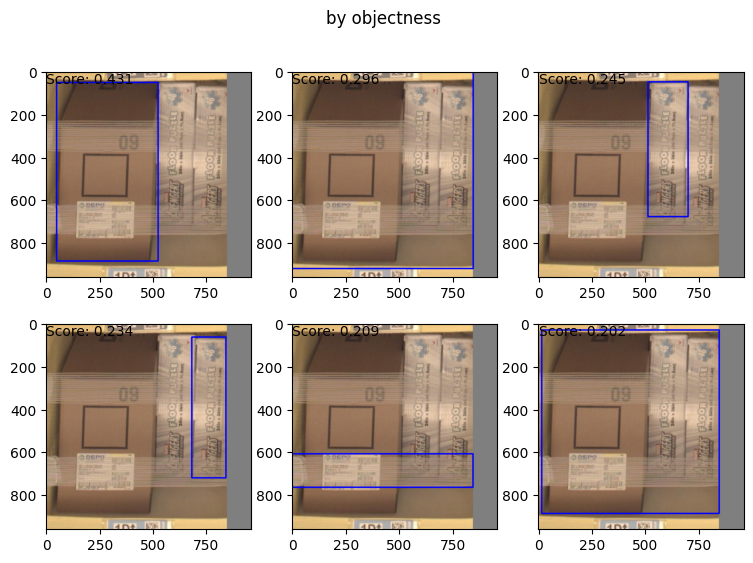

In [ ]:
from binsense.plot_utils import show_bbox_ingrid

img, box_scores = get_topk_bboxes('../docs/sample_bin.jpg', 6)
show_bbox_ingrid(np.array(img), box_scores, grid=(2, 3), title="by objectness")

In [18]:
from binsense.lightning.config import Config as TrainConfig

AttributeError: 'Config' object has no attribute 'keys'

In [15]:
from binsense.lightning.metrics import QueryAccuracy
from binsense import torch_utils as tutls
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt

exists_acc = QueryAccuracy(criteria="exists")
exists_acc(
    preds=tutls.to_int_tensor([1, 0, 2, 100, 1]), 
    targets=tutls.to_int_tensor([0, 0, 2, 4, 0]))
exists_acc(
    preds=tutls.to_int_tensor([1, 2]), 
    targets=tutls.to_int_tensor([0, 2]))
val = exists_acc.compute().item()
print(val, 4/7)
assert round(4/7, 1) == round(val, 1)

matches_acc = QueryAccuracy(criteria="matches")
matches_acc(
    preds=tutls.to_int_tensor([1, 0, 2, 100, 1]), 
    targets=tutls.to_int_tensor([0, 0, 2, 4, 0]))
val = matches_acc.compute().item()
print(val, 2/5)
assert round(2/5, 1) == round(val, 1)

meets_acc = QueryAccuracy(criteria="meets")
meets_acc(
    preds=tutls.to_int_tensor([0, 1, 2, 4, 0, 10]), 
    targets=tutls.to_int_tensor([1, 0, 2, 100, 0, 5]))
val = meets_acc.compute().item()
print(val, 3/6)
assert round(3/6, 1) == round(val, 1)

conf_matrix = MulticlassConfusionMatrix(num_classes=6)
preds=tutls.to_int_tensor([0, 1, 2, 4, 0, 10])
targets=tutls.to_int_tensor([1, 0, 2, 100, 0, 5])
pred_classes = preds.clone()
pred_classes[pred_classes > 4] = 5
tgt_classes = targets.clone()
tgt_classes[tgt_classes > 4] = 5
conf_matrix(pred_classes, tgt_classes)

f, ax = plt.subplots(1, 1, figsize = (10,7))
f, _ = conf_matrix.plot(ax=ax)
plt.close(f)
f


0.5714285969734192 0.5714285714285714
0.4000000059604645 0.4
0.5 0.5


matplotlib.figure.Figure

In [1]:

from binsense.lightning.config import Config as TrainConfig
from binsense.embed_datastore import SafeTensorEmbeddingDatastore
from binsense.lightning.dataset import LitInImageQuerierDM
from binsense.lightning.model import LitInImageQuerier
from binsense.owlv2.processor import Owlv2ImageProcessor
from binsense.cli.owlv2.train import train, _get_baseline_model
from binsense import torch_utils as tutls
import logging, PIL, torch
from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

def _get_transform_fn(embed_ds):
    processor = Owlv2ImageProcessor()
    def transform(inputs):
        inputs['image'] = processor.preprocess(inputs['image'])['pixel_values'][0]
        inputs['query'] = embed_ds.get(inputs['query']).reshape((1, -1))
        return inputs
    return transform

cfg = TrainConfig()
embed_ds = SafeTensorEmbeddingDatastore(cfg.embed_store_dirpath, read_only=True)
data_module = LitInImageQuerierDM(
    data_dir=cfg.data_dirpath,
    csv_filepath=cfg.data_csv_filepath, 
    batch_size=2, 
    num_workers=0, transform=_get_transform_fn(embed_ds))
data_module.setup(stage=None)
lmodel = LitInImageQuerier(_get_baseline_model())

def check_for_empty(dl, desc):
    for batch in tqdm(dl, desc=desc):
        if len(batch[0]) == 0 or len(batch[1]) == 0:
            print("empty batch")

train_dl = data_module.train_dataloader()
val_dl = data_module.val_dataloader()

image_path = '/Users/n0c09jf/code/github/binsense/_data/bin/filtered_dataset/train/images/02278.jpg'
inputs_0 = _get_transform_fn(embed_ds)({"image": PIL.Image.open(image_path), "query": "B00K5NELR0"})
inputs_1 = _get_transform_fn(embed_ds)({"image": PIL.Image.open(image_path), "query": "B00PLRGOKC"})
inputs = { 
        "image": torch.stack([inputs_0["image"],  inputs_1["image"]]), 
        "query": torch.stack([inputs_0["query"], inputs_1["query"]]),
        "idx": torch.stack([tutls.to_int_tensor(198), tutls.to_int_tensor(199)])
}

gt_labels = [tutls.empty_int_tensor(), tutls.to_int_tensor([0, 0])]
gt_counts = [tutls.to_int_tensor(0), tutls.to_int_tensor(2)]
gt_boxes = [
    tutls.empty_float_tensor(), 
    tutls.to_float_tensor([[0.4919262230396271, 0.5147766323024056, 0.32922131147540984,0.8304810996563573], 
                           [0.7953483462333679, 0.5082130584192439, 0.3489344262295082, 0.7902061855670103]])
]
targets = {
    "count": gt_counts,
    "labels": gt_labels,
    "boxes": gt_boxes
}
print(lmodel.training_step((inputs, targets), 0))
# outputs = lmodel.model(inputs)
# lmodel.loss(outputs, targets)
# print(outputs["pred_boxes"].shape, outputs["pred_logits"].shape, targets)
# preds = lmodel.select_preds(outputs)
# print(lmodel._compute_metrics(preds, targets, 'train', inputs["idx"]))
# [p.shape for p in preds["pred_boxes"]]

# check_for_empty(train_dl, "train_dl")
# check_for_empty(val_dl, "val_dl")

# for i, batch in tqdm(enumerate(train_dl), desc="train_dl"):
#     if len(batch[1]["boxes"]) != 2:
#         print(batch[0]["idx"])
        
#     if batch[1]["boxes"][1].shape[0] == 2 \
#         and batch[1]["boxes"][1][0].shape[0] > 1 \
#         and batch[1]["boxes"][1][0][0].item() == 0.4919262230396271:
#         print(batch[1])
#         outputs = lmodel.model(batch[0])
#         if len(outputs["pred_boxes"]) == 0:
#             print(batch[0]["idx"])
#         else:
#             preds = lmodel.select_preds(outputs)
#             if len(preds["pred_boxes"]) == 0:
#                 print(batch[0]["idx"])


2024-04-12 06:46:17,123 INFO : 
                train/val/test split, 
                len=1007/95/140, 
                ratio=0.8/0.1/0.1
            
2024-04-12 06:46:18,475 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.


tensor(12.9016, grad_fn=<AddBackward0>)


/usr/local/Caskroom/miniconda/base/envs/binsense_condaenv/lib/python3.11/site-packages/lightning/pytorch/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [2]:
from binsense.cli.owlv2.train import train
from binsense.lightning.config import Config as TrainConfig
from lightning.pytorch.loggers import TensorBoardLogger
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')
cfg = TrainConfig()
tlogger = TensorBoardLogger(cfg.tb_logs_dir, version='test')
train(
    min_epochs=1, 
    batch_size=2, 
    fast_dev_run=1,
    logger=tlogger,
    profiler='simple',
    use_focal_loss=True,
    eos_coef=0.0
)

Config:  Config(data_dirpath='/Users/n0c09jf/code/github/binsense/_data/bin', data_csv_filepath='/Users/n0c09jf/code/github/binsense/_data/bin/inimage_queries.csv', embed_store_dirpath='/Users/n0c09jf/code/github/binsense/_data/bin/embed_store', chkpt_dirpath='/Users/n0c09jf/code/github/binsense/_data/bin/chkpts', results_csv_filepath='/Users/n0c09jf/code/github/binsense/_data/bin/test_results.csv', experiment_version=None, learning_rate=1e-05, lr_decay_rate=0.95, min_epochs=1, max_epochs=500, batch_size=2, num_workers=0, reg_loss_coef=0.5, giou_loss_coef=1.0, label_loss_coef=1.5, eos_coef=0.0, use_focal_loss=True, focal_loss_alpha=0.25, focal_loss_gamma=2.0, iou_threshold=0.98, nms_threshold=1, score_threshold=0.998)
kwargs:  {'fast_dev_run': 1, 'logger': <lightning.pytorch.loggers.tensorboard.TensorBoardLogger object at 0x16c26e750>, 'profiler': 'simple'}


2024-04-17 18:59:58,420 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
2024-04-17 19:00:00,360 INFO : 
                train/val/test split, 
                len=1015/101/126, 
                ratio=0.8/0.1/0.1
            

   | Name              | Type                      | Params
-----------------------------------------------------------------
0  | model             | OwlV2InImageQuerier       | 91.2 M
1  | loss              | DETRMultiBoxLoss          | 0     
2  | train_exists_acc  | QueryAccuracy             | 0     
3  | val_exists_acc    | QueryAccuracy             | 0     
4  | test_exists_acc   | QueryAccuracy             | 0     
5  | train_conf_matrix | MulticlassConfusio

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.
FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                    

In [1]:
from binsense.cli.owlv2.train import test
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

test(
    batch_size=2, 
    ckpt_fname='run_v4_best_loss.ckpt',
    experiment_version='test_playground',
    fast_dev_run=1,
    score_threshold=0.95)

Config:  Config(data_dirpath='/Users/n0c09jf/code/github/binsense/_data/bin', data_csv_filepath='/Users/n0c09jf/code/github/binsense/_data/bin/inimage_queries.csv', embed_store_dirpath='/Users/n0c09jf/code/github/binsense/_data/bin/embed_store', chkpt_dirpath='/Users/n0c09jf/code/github/binsense/_data/bin/chkpts', results_csv_filepath='/Users/n0c09jf/code/github/binsense/_data/bin/test_results.csv', results_topk_bboxes=10, experiment_version=None, learning_rate=1e-05, lr_decay_rate=0.95, min_epochs=10, max_epochs=100, batch_size=2, num_workers=0, reg_loss_coef=0.5, giou_loss_coef=1.0, label_loss_coef=1.5, eos_coef=1.0, use_focal_loss=True, focal_loss_alpha=0.25, focal_loss_gamma=2.0, match_cost_label=0.25, match_cost_bbox=0.75, match_cost_giou=2.0, iou_threshold=0.98, nms_threshold=1, score_threshold=0.95, use_no_object_class=False)
kwargs:  {'fast_dev_run': 1}


2024-04-19 01:53:19,590 INFO : vision_config is None. initializing the Owlv2VisionConfig with default values.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
2024-04-19 01:53:21,989 INFO : 
                train/val/test split, 
                len=569/44/77, 
                ratio=0.8/0.1/0.1
            
Restoring states from the checkpoint path at /Users/n0c09jf/code/github/binsense/_data/bin/chkpts/run_v4_best_loss.ckpt
/usr/local/Caskroom/miniconda/base/envs/binsense_condaenv/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.2, which is newer than your current Lightning version: v2.2.1
Loaded model weights from the checkpoint at /Users/n0c09jf/code/github/binsense/_data/bin/chkpts/r

Testing: |          | 0/? [00:00<?, ?it/s]

2024-04-19 01:53:22,425 INFO : backing up /Users/n0c09jf/code/github/binsense/_data/bin/testresults_test_playground.csv to /Users/n0c09jf/code/github/binsense/_data/bin/testresults_test_playground.csv.5.bkp


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_exists_acc                0.0
    test_matches_acc                0.0
     test_meets_acc                 0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [1]:
from binsense.dataset_util import COCODatasetBuilder, YoloDatasetBuilder
from binsense import config as cfg
from binsense.dataset_util import ImageData, DataTag

from typing import List

import numpy as np

import os

ds = COCODatasetBuilder.build_from_file("/Users/n0c09jf/Downloads/annotations/instances_val2017.json")
images_data = ds.get_images()
r_idxs = np.random.randint(0, len(images_data), 300)
filtered_images_data = [images_data[i] for i in r_idxs]

cat_ids = []
cats = {}
for cat in ds.data['categories']:
    cat_ids.append(cat["id"])
    cats[cat["id"]] = cat["name"]
cat_ids = sorted(cat_ids)
cat_names = [cats[i] for i in cat_ids]
print(cat_ids)
print(cat_names)

yolobuild = YoloDatasetBuilder()
yolobuild.add_categories(cat_names)

def add_to_yolo(images_data: List[ImageData], tag: DataTag):
    for img_data in images_data:
        img_id = yolobuild.add_image(
            img_name=img_data.name,
            tag=tag,
            img_path=os.path.join(f"/Users/n0c09jf/Downloads/val2017/{img_data.name}")
        )
        for bbox in ds.get_bboxes(img_data.name):
            category_id = yolobuild.add_category(bbox.label)
            yolobuild.add_bbox(img_id, category_id, bbox.to_array())

train_len, val_len, test_len = (210, 30, 60)
add_to_yolo(filtered_images_data[0:train_len], DataTag.TRAIN)
add_to_yolo(filtered_images_data[train_len:val_len], DataTag.VALID)
add_to_yolo(filtered_images_data[train_len+val_len:], DataTag.TEST)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse

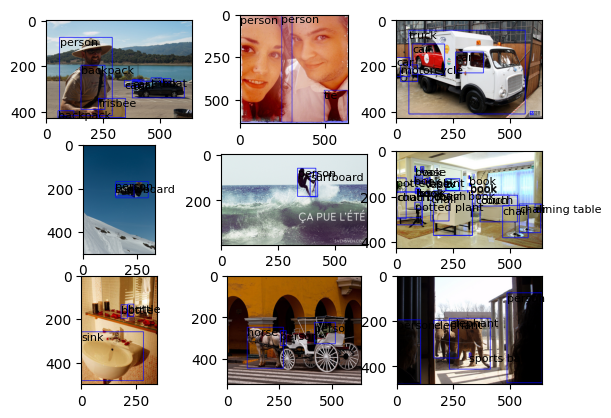

In [12]:
from matplotlib import pyplot as plt
from binsense.plot_utils import plot_bboxes
from binsense.img_utils import convert_cxy_xy_and_scale

import PIL


yolo_ds = yolobuild.build()
def show_image(img_data, ax):
    img_pil = PIL.Image.open(img_data.path)
    boxes_data = yolo_ds.get_bboxes(img_data.name)
    bboxes_cxy = np.array([b.to_array() for b in boxes_data])
    bboxes_xy = convert_cxy_xy_and_scale(bboxes_cxy, (img_pil.width, img_pil.height))
    labels = [b.label for b in boxes_data]
    plot_bboxes(np.array(img_pil), bboxes_xy, labels, ax=ax)

f, axs = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        show_image(yolo_ds.get_images()[np.random.randint(0, 200)], ax=axs[i][j])



In [3]:
from binsense.dataprep.config import coco_cfg

cfg = coco_cfg()
yolobuild.build().to_file(cfg.filtered_dataset_path, format='yolov8')

In [29]:
from binsense.dataprep.embedding_util import BBoxDatasetEmbedder
from binsense.dataprep.config import coco_cfg, DataPrepConfig
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')
cfg = coco_cfg()
print(list(filter(lambda x: x[0] != '_', [n for n in cfg.__dir__()])))
print(cfg.__getattribute__('robo_project'))
cfg.__setattr__('robo_project', 'somethingelse')
print(cfg.__getattribute__('robo_project'))

['root_dir', 'dataset_download_path', 'filtered_dataset_path', 'inimage_queries_csv', 'embed_store_dirpath', 'raw_data_root_dir', 'data_split_images_dir', 'data_split_labels_dir', 'raw_data_img_extn', 'data_split_filepath', 'label_chkpt_filepath', 'bbox_chkpt_filepath', 'robo_upload_dir', 'batch_size', 'dataset_class', 'rfmeta_file_path', 'inimage_queries_pos_neg_ratio', 'roboql_dataset_url', 'robo_workspace', 'robo_project', 'robo_ann_group', 'robo_dataset_version', 'robo_workspace_id', 'robo_project_id', 'robo_meta_check_tags']
binsense_bbox_mini
somethingelse


In [1]:
from binsense.dataprep.metadata import BinMetadataLoader
from binsense.config import DATA_DIR
import logging, os

logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s : %(message)s')

print('process', os.getpid())
bin_df, item_df = BinMetadataLoader().load(
    source_dir=os.path.join(DATA_DIR, 'amzbin'), 
    max_workers=15)
print(bin_df.shape, item_df.shape)

2024-04-26 03:10:36,000 INFO : reading csv files


process 59594
(536433, 7) (1415740, 12)


In [7]:
import torch

class BackPropDemo(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.L1 = torch.nn.Linear(1, 2, bias=False)
        self.L2 = torch.nn.Linear(2, 4, bias=False)
        self.H1 = torch.nn.Linear(4, 1, bias=False)
        self.H2 = torch.nn.Linear(4, 1, bias=False)
        self.fn = torch.nn.functional.sigmoid
    
    def forward(self, X):
        h = self.L1(X)
        h = self.L2(h)
        h1 = self.H1(h)
        h2 = self.H2(h)
        return self.fn(h1), self.fn(h2)

def freeze_layer(layer):
    for p in layer.parameters():
        p.requires_grad = False

model = BackPropDemo()
freeze_layer(model.L1)
freeze_layer(model.L2)
optim = torch.optim.SGD(model.parameters(), lr=0.1)
lossfn = torch.nn.functional.binary_cross_entropy

print("*********************************************")
print("********* demo training H1  head ************")
print("*********************************************")
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)
optim.zero_grad()
y1, y2 = model(torch.as_tensor([0.5]))
print("y1 -->", y1, "y2 -->", y2)
y1_loss = lossfn(y1, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
# y2_loss = lossfn(y2, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
print("loss computation followed by gradient update")
y1_loss.backward()
optim.step()
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)

print("*********************************************")
print("********* demo training H2  heads ***********")
print("*********************************************")
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)
optim.zero_grad()
y1, y2 = model(torch.as_tensor([0.5]))
print("y1 -->", y1, "y2 -->", y2)
# y1_loss = lossfn(y1, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
y2_loss = lossfn(y2, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
y2_loss.backward()
optim.step()
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)

print("*********************************************")
print("********* demo training H1 & H2  heads ******")
print("*********************************************")
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)
optim.zero_grad()
y1, y2 = model(torch.as_tensor([0.5]))
print("y1 -->", y1, "y2 -->", y2)
y1_loss = lossfn(y1, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
y2_loss = lossfn(y2, torch.as_tensor([1], dtype=torch.float32), reduction='mean')
total_loss = y1_loss + y2_loss
total_loss.backward()
optim.step()
print("H1 -->", model.H1.weight)
print("H2 -->", model.H2.weight)


*********************************************
********* demo training H1  head ************
*********************************************
H1 --> Parameter containing:
tensor([[-0.0411,  0.0506,  0.3532, -0.0599]], requires_grad=True)
H2 --> Parameter containing:
tensor([[ 0.4521, -0.2107,  0.3239,  0.4441]], requires_grad=True)
y1 --> tensor([0.5056], grad_fn=<SigmoidBackward0>) y2 --> tensor([0.4806], grad_fn=<SigmoidBackward0>)
loss computation followed by gradient update
H1 --> Parameter containing:
tensor([[-0.0472,  0.0538,  0.3549, -0.0619]], requires_grad=True)
H2 --> Parameter containing:
tensor([[ 0.4521, -0.2107,  0.3239,  0.4441]], requires_grad=True)
*********************************************
********* demo training H2  heads ***********
*********************************************
H1 --> Parameter containing:
tensor([[-0.0472,  0.0538,  0.3549, -0.0619]], requires_grad=True)
H2 --> Parameter containing:
tensor([[ 0.4521, -0.2107,  0.3239,  0.4441]], requires_grad=True)